# Classification

In [39]:
using RDatasets
using ScikitLearn.CrossValidation
using Plots 
using DecisionTree 
using Distances
using NearestNeighbors
using Random
using LinearAlgebra
using DataStructures 
using LIBSVM

## Data preprocessing

In order to try different classification algorithms, I going to use the well-known Iris dataset.

In [2]:
irisDataset = dataset("datasets", "iris");
@show typeof(irisDataset);
@show size(irisDataset)

typeof(irisDataset) = DataFrame
size(irisDataset) = (150, 5)


(150, 5)

In [3]:
describe(irisDataset)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,SepalLength,5.84333,4.3,5.8,7.9,,,Float64
2,SepalWidth,3.05733,2.0,3.0,4.4,,,Float64
3,PetalLength,3.758,1.0,4.35,6.9,,,Float64
4,PetalWidth,1.19933,0.1,1.3,2.5,,,Float64
5,Species,,setosa,,virginica,3,,"CategoricalValue{String,UInt8}"


I extract the features and the labels from the dataframe.

In [4]:
X = Matrix(irisDataset[:,1:4])
labels = Vector(irisDataset[:, 5])

println("Size of X = $(size(X))")
println("Size of labels = $(size(labels))")

Size of X = (150, 4)
Size of labels = (150,)


#### Standarize the features

Even though the different features have very similar ranges of values, I'm going to standarize the data.

In [5]:
using Statistics 

function standarize!(X)
    for j = 1:size(X,2)
        X[:,j] = (X[:,j] .- mean(X[:,j])) ./ std(X[:,j])
    end
    nothing    
end

standarize! (generic function with 1 method)

In [6]:
standarize!(X)

#### Encode the labels

In [7]:
lm = labelmap(labels)
Y = labelencode(lm, labels)
@show unique(Y)
@show size(Y);

unique(Y) = [1, 2, 3]
size(Y) = (150,)


#### Obtain the 10-fold cross validation partitions

In [19]:
K = 10
n = size(Y,1);
?KFold

LoadError: syntax: invalid identifier name "?"

In [20]:
kf = KFold(n, n_folds=K, shuffle=true, random_state=1)

10-element Array{Tuple{Array{Int64,1},Array{Int64,1}},1}:
 ([2, 3, 4, 5, 6, 8, 9, 10, 11, 12  …  139, 140, 141, 142, 143, 144, 146, 147, 148, 150], [40, 16, 22, 112, 134, 106, 90, 51, 149, 67, 111, 114, 1, 7, 145])
 ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  138, 141, 142, 143, 144, 145, 146, 148, 149, 150], [136, 80, 140, 15, 91, 92, 73, 133, 25, 36, 105, 99, 109, 147, 139])
 ([1, 4, 5, 6, 7, 8, 9, 10, 11, 12  …  139, 140, 142, 143, 144, 145, 146, 147, 148, 149], [3, 21, 33, 44, 85, 141, 2, 102, 81, 38, 86, 43, 24, 150, 126])
 ([1, 2, 3, 4, 5, 6, 7, 9, 10, 11  …  140, 141, 142, 143, 145, 146, 147, 148, 149, 150], [110, 47, 144, 97, 116, 37, 95, 89, 61, 26, 8, 113, 60, 55, 52])
 ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  140, 141, 142, 143, 144, 145, 147, 148, 149, 150], [88, 56, 117, 39, 146, 125, 49, 32, 69, 46, 130, 58, 77, 115, 20])
 ([1, 2, 3, 4, 5, 6, 7, 8, 11, 12  …  140, 141, 142, 143, 144, 145, 146, 147, 149, 150], [66, 30, 10, 148, 135, 9, 18, 35, 41, 45, 65, 19, 53, 124, 100])
 ([1, 2, 3,

In [22]:
kf[1]


([2, 3, 4, 5, 6, 8, 9, 10, 11, 12  …  139, 140, 141, 142, 143, 144, 146, 147, 148, 150], [40, 16, 22, 112, 134, 106, 90, 51, 149, 67, 111, 114, 1, 7, 145])

#### Define an accuracy function

In [63]:
function hit_rate(Y, YPred)
    sum(Y .== YPred) / size(Y,1)
end 

hit_rate (generic function with 1 method)

In [11]:
accuracy = Dict()

Dict{Any,Any} with 0 entries

## Method 1: Support Vector Machine

In [24]:
svmScores = []

allInd = Set(Array(1:size(Y,1)))

for (train, test) in kf    
    Xtrain = X[train, :]
    Xtest = X[test, :]
    Ytrain = Y[train]
    Ytest = Y[test]
    
    # Train model 
    model = svmtrain(Xtrain', Ytrain)
    # Make predictions
    Ypred, decisionValues = svmpredict(model, Xtest')
    # Save hit rate of the fold
    push!(svmScores, hit_rate(Ytest, Ypred))
end

accuracy["SVM"] = mean(svmScores)

0.9666666666666668

## Method 2: 5 Nearest Neighbours

In [25]:
k = 5
knnScores = []

allInd = Set(Array(1:size(Y,1)))

for (train, test) in kf    
    Xtrain = X[train, :]
    Xtest = X[test, :]
    Ytrain = Y[train]
    Ytest = Y[test]
    
    # Train KDTree
    kdtree = KDTree(Xtrain')
    
    indxs, dists = knn(kdtree, Xtest', k, true)
    c = Ytrain[hcat(indxs...)]
    labels = map(i->counter(c[:,i]),1:size(c,2))
    # Make predictions
    Ypred = map(i->parse(Int,string(argmax(DataFrame(labels[i])[1,:]))),
                1:size(c,2))
    # Sabe hit rate
    push!(knnScores, hit_rate(Ypred, Ytest))
end

accuracy["$(k)NN"] = mean(knnScores)
  

0.9466666666666669

## Method 3: Decision Trees

In [55]:
dtScores = [] 

for (train, test) in kf    
    Xtrain = X[train, :]
    Xtest = X[test, :]
    Ytrain = Y[train]
    Ytest = Y[test]
    
    # Create and fit model 
    model = DecisionTreeClassifier(max_depth=2)
    DecisionTree.fit!(model, Xtrain, Ytrain)
    
    # Print the tree 
    #print_tree(model, 5)
    
    # Make predictions
    Ypred = DecisionTree.predict(model, Xtest)
    
    # Save hit rate 
    push!(dtScores, hit_rate(Ypred, Ytest))    
    
end

accuracy["DecisionTree"] = mean(dtScores)

0.9133333333333334

For the models in ScikitLearn (DecisionTree, RandomForest, ...) the Cross Validation can be done easier using the ScikitLearn.CrossValidation: cross_val_score function.

In [57]:
model = DecisionTreeClassifier(max_depth=2)
cross_val_score(model, X, Y. cv=5)

5-element Array{Float64,1}:
 0.9333333333333333
 0.9666666666666667
 0.9
 0.8666666666666667
 1.0

## Method 4: Random Forest

In [61]:
model = RandomForestClassifier(n_trees=10) 
accuracy["RandomForest(10)"] = mean(cross_val_score(model, X, Y, cv=10))

0.9666666666666668

## Comparison

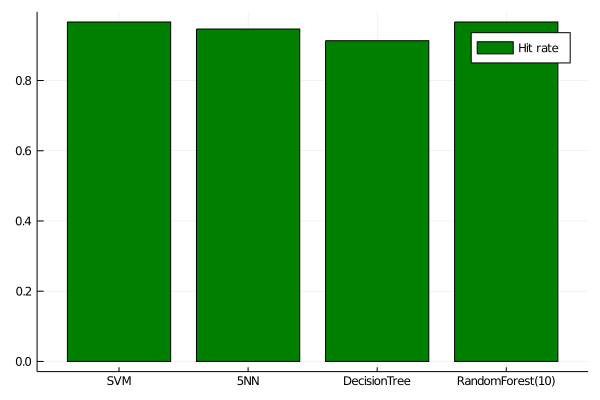

In [62]:
bar(collect(keys(accuracy)), collect(values(accuracy)), fillcolor=:green,label="Hit rate")